## Introduction


The goal here is to build an animator for the bio-optical sensor ensemble.


BioOptical instruments


- Photosynthetically Available Radiation (PAR)
- Spectral Irradiance 
- Spectrophotometer (sometimes 'AC-S') 
- Fluorometers


Where/when: Oregon Slope Base (RCA), March 2021 

These profilers 
ascend from 200 meters to near-surface nine times per day, thence returning to a parked
or resting state at 200 meters. The near-noon and near-midnight profiles run
a little longer as they include equilibration stops for the pH sensor.


Co-mounted profiler CTD pressure/depth information is integrated in the OOI fluorometer data product 
as a Data Variable. This means every fluorescence measurement has an associated depth. 
To provide further context, the CTD salinity, temperature and dissolved oxygen are imported as well.



## References


* This repository, home directory: **`BioOptics.ipynb`**
* Chase, Alison, et al. "Decomposition of in situ particulate absorption spectra." Methods in Oceanography 7 (2013): 110-124. Available via online search.
* Han, Bo-Ping, et al. "Effect of photoinhibition on algal photosynthesis: a dynamic model." Journal of plankton research 22.5 (2000): 865-885.
* [Phytoplankton productivity lecture slides (Marlon Lewis, 2004)](https://slidetodoc.com/phytoplankton-and-primary-productivity-introduction-to-biological-oceanography/)


In [ ]:
from NotebookModule import *

#### From this point down: Content is under revision June 2022

In [23]:
# filter() operates on a time series DataArray passed in as 'v'. It is set up to point to multiple possible
#   smoothing kernels but has just one at the moment, called 'hat'.


def filter(v, ftype='hat', control1=3):
    """Operate on an XArray data array (with some checks) to produce a filtered version"""
    # pre-checks
    if not v.dims[0] == 'time': return v

    if ftype == 'hat': 
        n_passes = control1        # should be a kwarg
        len_v = len(v)
        for n in range(n_passes):
            source_data = np.copy(v) if n == 0 else np.copy(smooth_data)
            smooth_data = [source_data[i] if i == 0 or i == len_v - 1 else \
                0.5 * source_data[i] + 0.25 * (source_data[i-1] + source_data[i + 1]) \
                for i in range(len_v)]
        return smooth_data
    return v



## Fluorometer + CTD Data Load: chlor-a, CDOM, backscatter

The following cell identifies a specific CTD dataset and determines the start and end indices of 
ascents, descents and rests for a profiler. It does not however determine the stair step times for
an intervallic descent. These are done twice per day by the RCA shallow profilers to give their
pH sensors time to stabilize (I believe).

Incidentally the default dataset is 9 profiles per day over 31 days but the very last profile seems 
to have been skipped so there are 278 profiles found.

In [24]:
# loading CTD/DO + nitrate + fluorometer by copy/paste from nbk 01 A

ctd_source         = './data/rca/ctd/'; 
fluorometer_source = './data/rca/fluorescence/'

ctd_data           = "osb_ctd_jan2019_1min.nc"; 
fluorometer_data   = 'osb_sp_fluor_jan2019.nc'

ds_CTD   = xr.open_dataset(ctd_source + ctd_data)
ds_Fluor = xr.open_dataset(fluorometer_source + fluorometer_data)

ds_Fluor.data_vars

Data variables:
    fluorometric_chlorophyll_a           (time) float64 ...
    fluorometric_cdom                    (time) float64 ...
    total_volume_scattering_coefficient  (time) float64 ...
    seawater_scattering_coefficient      (time) float64 ...
    optical_backscatter                  (time) float64 ...
    int_ctd_pressure                     (time) float64 ...

### Data variables 

Note that backscatter is present as three variables: seawater, optical and total. This deserves further comment.


Let's begin by comparing all three.

In [25]:
# first profile of 2019
time0, time1 = dt64('2019-01-01T00:26:05'), dt64('2019-01-01T01:37:55')

ds_CTD_time_slice   = ds_CTD.sel(time=slice(time0, time1))
ds_fluor_time_slice = ds_Fluor.sel(time=slice(time0, time1))

ds_fluor_time_slice.data_vars

Data variables:
    fluorometric_chlorophyll_a           (time) float64 ...
    fluorometric_cdom                    (time) float64 ...
    total_volume_scattering_coefficient  (time) float64 ...
    seawater_scattering_coefficient      (time) float64 ...
    optical_backscatter                  (time) float64 ...
    int_ctd_pressure                     (time) float64 ...

...


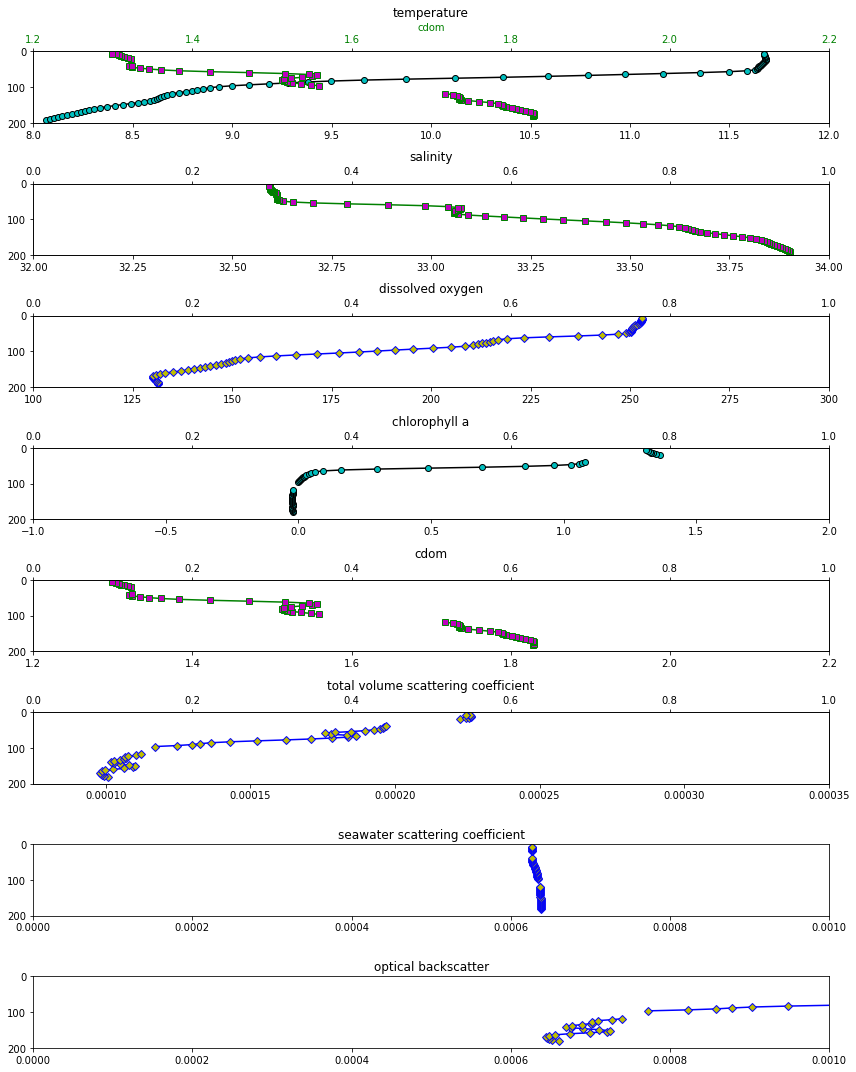

In [30]:
ctd_t = ds_CTD_time_slice['seawater_temperature'];       smooth_ctd_t = filter(ctd_t)
ctd_s = ds_CTD_time_slice['practical_salinity'];         smooth_ctd_s = filter(ctd_s)
ctd_o = ds_CTD_time_slice['corrected_dissolved_oxygen']; smooth_ctd_o = filter(ctd_o)

ctd_d = ds_CTD_time_slice['seawater_pressure']

fluor_a = ds_fluor_time_slice['fluorometric_chlorophyll_a'];          smooth_fluor_a = filter(fluor_a)
fluor_c = ds_fluor_time_slice['fluorometric_cdom'];                   smooth_fluor_c = filter(fluor_c)
fluor_v = ds_fluor_time_slice['total_volume_scattering_coefficient']; smooth_fluor_v = filter(fluor_v)
fluor_s = ds_fluor_time_slice['seawater_scattering_coefficient'];     smooth_fluor_s = filter(fluor_s)
fluor_o = ds_fluor_time_slice['optical_backscatter'];                 smooth_fluor_o = filter(fluor_o)

fluor_d = ds_fluor_time_slice['int_ctd_pressure']

temperature_lbound, temperature_ubound           =   8.,        12.
salinity_lbound, salinity_ubound                 =  32.,        34.
dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
chlora_lbound, chlora_ubound                     =  -1.,         2.
cdom_lbound, cdom_ubound                         =   1.2,        2.2
vol_lbound, vol_ubound                       =   0.000075,    .00035
sea_lbound, sea_ubound                       =   0.0,    .001
opt_lbound, opt_ubound                       =   0.0,    .001

fig, axs = plt.subplots(8,1,figsize=(12, 15), tight_layout=True)

compare_unfiltered = False

if compare_unfiltered:
    axs[0].plot(ctd_t + 0.5, ctd_d, marker='o', markersize = 6., color='k', markerfacecolor='r')
    axs[1].plot(ctd_s + 0.5, ctd_d, marker='s', markersize = 6., color='g', markerfacecolor='r')
    axs[2].plot(ctd_o + 20., ctd_d, marker='D', markersize = 6., color='b', markerfacecolor='r')
    axs[3].plot(fluor_a + 0.5, fluor_d, marker='o', markersize = 6., color='k', markerfacecolor='r')
    axs[4].plot(fluor_c + 0.5, fluor_d, marker='s', markersize = 6., color='g', markerfacecolor='r')
    axs[5].plot(fluor_v + 20., fluor_d, marker='D', markersize = 6., color='b', markerfacecolor='r')

    
axs[0].plot(smooth_ctd_t, ctd_d, marker='o', markersize = 6., color='k', markerfacecolor='c')
axs[0].set(xlim = (temperature_lbound, temperature_ubound), ylim = (200., 0.), title='temperature')

axs[1].plot(smooth_ctd_s, ctd_d, marker='s', markersize = 6., color='g', markerfacecolor='m')
axs[1].set(xlim = (salinity_lbound, salinity_ubound), ylim = (200., 0.), title='salinity')

axs[2].plot(smooth_ctd_o, ctd_d, marker='D', markersize = 6., color='b', markerfacecolor='y')
axs[2].set(xlim = (dissolved_oxygen_lbound, dissolved_oxygen_ubound), ylim = (200., 0.), title='dissolved oxygen')

axs[3].plot(smooth_fluor_a, fluor_d, marker='o', markersize = 6., color='k', markerfacecolor='c')
axs[3].set(xlim = (chlora_lbound, chlora_ubound), ylim = (200., 0.), title='chlorophyll a')

axs[4].plot(smooth_fluor_c, fluor_d, marker='s', markersize = 6., color='g', markerfacecolor='m')
axs[4].set(xlim = (cdom_lbound, cdom_ubound), ylim = (200., 0.), title='cdom')

axs[5].plot(smooth_fluor_v, fluor_d, marker='D', markersize = 6., color='b', markerfacecolor='y')
axs[5].set(xlim = (vol_lbound, vol_ubound), ylim = (200., 0.), title='total volume scattering coefficient')

axs[6].plot(smooth_fluor_s, fluor_d, marker='D', markersize = 6., color='b', markerfacecolor='y')
axs[6].set(xlim = (sea_lbound, sea_ubound), ylim = (200., 0.), title='seawater scattering coefficient')

axs[7].plot(smooth_fluor_o, fluor_d, marker='D', markersize = 6., color='b', markerfacecolor='y')
axs[7].set(xlim = (opt_lbound, opt_ubound), ylim = (200., 0.), title='optical backscatter')

# sets up companion plots with shared y-axis, independent 'twin' x-axis
axsTwin = [axs[i].twiny() for i in range(6)]
axsTwin[0].set_xlabel('cdom', color='g')
axsTwin[0].plot(smooth_fluor_c, fluor_d, marker='s', markersize = 6., color='g', markerfacecolor='m')
axsTwin[0].tick_params(axis='x', labelcolor='g')
axsTwin[0].set(xlim = (cdom_lbound, cdom_ubound), ylim = (200., 0.))

print('...')

## animating the time series

The following animates all 278 profiles from January 2019 at Oregon Slope Base: CTD + Fluorometer.
I moved the charts around to make the layout easier to see all at once; CTD on the left and Fluorometer on the right. 


In [9]:
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML, Video


animating frame 278 of 278


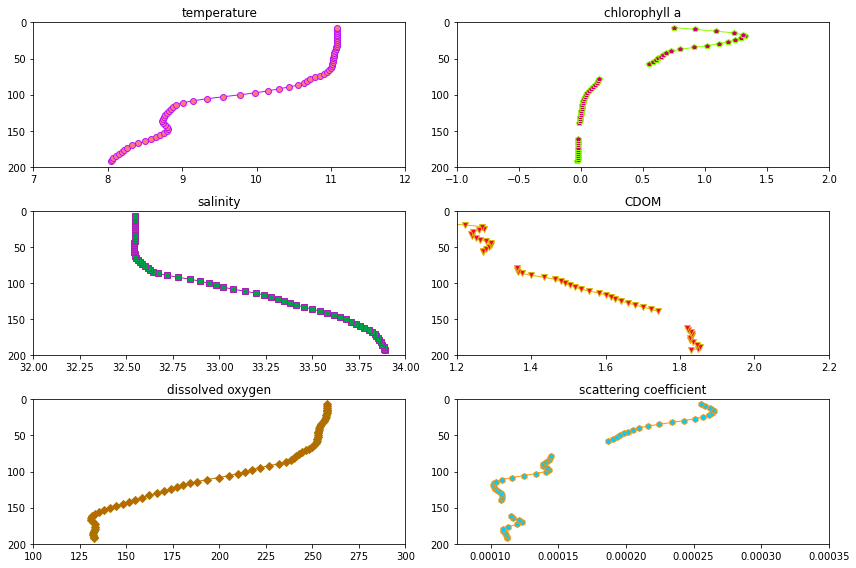

In [10]:
temperature_lbound, temperature_ubound           =   7.,        12.
salinity_lbound, salinity_ubound                 =  32.,        34.
dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
chlora_lbound, chlora_ubound                     =  -1.,         2.
cdom_lbound, cdom_ubound                         =   1.2,        2.2
scatt_lbound, scatt_ubound                       =   0.000075,    .00035
pressure_lbound, pressure_ubound                 = 200.,         0.

frame_number_global      = 0
frames_to_animate_global = 278

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(3, 2, figsize=(12,8), tight_layout=True)

ax[0][0].set_xlim((temperature_lbound, temperature_ubound))
ax[1][0].set_xlim((salinity_lbound, salinity_ubound))
ax[2][0].set_xlim((dissolved_oxygen_lbound, dissolved_oxygen_ubound))
ax[0][1].set_xlim((chlora_lbound, chlora_ubound))
ax[1][1].set_xlim((cdom_lbound, cdom_ubound))
ax[2][1].set_xlim((scatt_lbound, scatt_ubound))

ax[0][0].set_title('temperature')
ax[1][0].set_title('salinity')
ax[2][0].set_title('dissolved oxygen')
ax[0][1].set_title('chlorophyll a')
ax[1][1].set_title('CDOM')
ax[2][1].set_title('scattering coefficient')

for n in range(3): 
    for m in range(2):
        ax[n][m].set_ylim((pressure_lbound, pressure_ubound))

# .plot() returns a tuple of length 1 so we de-reference this using the trailing [0]
line = [ax[0][0].plot([], [], lw=1, marker='o', ms = 6., c='xkcd:neon purple', mfc='xkcd:salmon pink')[0], \
        ax[1][0].plot([], [], lw=1, marker='s', ms = 6., c='xkcd:barney', mfc='xkcd:emerald')[0], \
        ax[2][0].plot([], [], lw=1, marker='D', ms = 6., c='xkcd:bronze', mfc='xkcd:orange brown')[0], \
        ax[0][1].plot([], [], lw=1, marker='p', ms = 6., c='xkcd:lime green', mfc='xkcd:deep pink')[0], \
        ax[1][1].plot([], [], lw=1, marker='v', ms = 6., c='xkcd:gold', mfc='xkcd:cherry red')[0], \
        ax[2][1].plot([], [], lw=1, marker='h', ms = 6., c='xkcd:tangerine', mfc='xkcd:bright sky blue')[0], \
       ]

# print(type(line), type(line[0]), 'first stop')

# initialization function: plot the background of each frame
def init():
    # print(type(line[0]))
    line[0].set_data([], [])
    line[1].set_data([], [])
    line[2].set_data([], [])
    line[3].set_data([], [])
    line[4].set_data([], [])
    line[5].set_data([], [])
    return line
    # was return (line0, line1,)

    
# animation function. This is called sequentially
def animated_chart(i):
    
    time0, time1 = dt64(ds_CTD.time[ascent_start_indices[i]].data), dt64(ds_CTD.time[ascent_end_indices[i]].data)
    
    ds_CTD_time_slice   =         ds_CTD.sel(time=slice(time0, time1))
    ds_fluor_time_slice = ds_Fluorometer.sel(time=slice(time0, time1))

    ctd_t = ds_CTD_time_slice['seawater_temperature'];       smooth_ctd_t = filter(ctd_t)
    ctd_s = ds_CTD_time_slice['practical_salinity'];         smooth_ctd_s = filter(ctd_s)
    ctd_o = ds_CTD_time_slice['corrected_dissolved_oxygen']; smooth_ctd_o = filter(ctd_o)

    ctd_d = ds_CTD_time_slice['seawater_pressure']

    fluor_a = ds_fluor_time_slice['fluorometric_chlorophyll_a'];          smooth_fluor_a = filter(fluor_a)
    fluor_c = ds_fluor_time_slice['fluorometric_cdom'];                   smooth_fluor_c = filter(fluor_c)
    fluor_s = ds_fluor_time_slice['total_volume_scattering_coefficient']; smooth_fluor_s = filter(fluor_s)

    fluor_d = ds_fluor_time_slice['int_ctd_pressure']

    # axs[0][0].plot(smooth_ctd_t, ctd_d, marker='o', markersize = 6., color='k', markerfacecolor='c')
    # axs[0][0].set(xlim = (temperature_lbound, temperature_ubound), ylim = (200., 0.), title='temperature')

    line[0].set_data(smooth_ctd_t, ctd_d)
    line[1].set_data(smooth_ctd_s, ctd_d)
    line[2].set_data(smooth_ctd_o, ctd_d)
    line[3].set_data(smooth_fluor_a, fluor_d)
    line[4].set_data(smooth_fluor_c, fluor_d)
    line[5].set_data(smooth_fluor_s, fluor_d)

    global frame_number_global, frames_to_animate
    frame_number_global += 1
    clear_output(wait = True)
    print("animating frame", frame_number_global, 'of', frames_to_animate_global)
        
    return line
    # was return (line0, line1,)

# call the animator. blit=True means only re-draw the parts that have changed.
# turned off while working elsewhere
if False:
    anim = animation.FuncAnimation(fig, animated_chart, init_func=init, frames=frames_to_animate_global, interval=100, blit=True, repeat=False)
    HTML(anim.to_html5_video())


In [12]:
# ani = animation.FuncAnimation(fig, MakeChart, interval=50, frames=15, repeat=True, blit=True) # frames > 278
if False: 
    anim.save('/home/ubuntu/Anim_CTD_and_Fluor_RCA_OSB_SP.mp4')    # prior code added , writer=writer)

In [4]:
Video("/home/ubuntu/Anim_CTD_and_Fluor_RCA_OSB_SP.mp4", embed=True)           # can include , embed=True or use line magic %matplotlib inline

## Data charting part 2: slider selection of profiles

This section takes the above results and provides a slider to drag through all 278 profiles in January 2019.

To see differentiation of these curves: Drop down to the next segment.

In [26]:
from ipywidgets import *
from traitlets import dlink

In [30]:
def ProfileChoicesChart(ctd, fluor, t, nf = 1):
    """
    Left/Right chart comparative: CTD x 3, fluorescence x 3; using time ranges in t[0, 1, 2, 3][i]; 
      using the 'hat' filter with param nf
    """
    
    nlr = [len(t[0]), len(t[2])]
    
    # t is a list of four lists so the slow / left index refers as 0, 1, 2, 3 to:
    #   left begin-time, left end-time, right begin-time, right end-time
    # Each of these four elements is a list of times corresponding to multiple profiles
    #   By choosing a slider value > 1 we can overplot sets of consecutive profiles
    
    nLeft = len(t[0])
    if not nLeft == len(t[1]): print('profile count mismatch left side'); return
    nRight = len(t[2])
    if not nRight == len(t[3]): print('profile count mismatch right side'); return
    
    temperature_lbound, temperature_ubound           =   8.,        12.
    salinity_lbound, salinity_ubound                 =  32.,        34.
    dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
    chlora_lbound, chlora_ubound                     =  -1.,         2.
    cdom_lbound, cdom_ubound                         =   1.2,        2.2
    scatt_lbound, scatt_ubound                       =   0.000075,    .00035

    fig, axs = plt.subplots(6,2,figsize=(16, 15), tight_layout=True)

    for lr in range(2):                           # lr = 0 for left, 1 for right
        for side_counter in range(nlr[lr]):       # side_counter counts first lefts then rights
        
            # these span across sensors for each (index = 'side_counter') time window
            ctd_slice   = ctd.sel(time=slice(t[lr*2][side_counter], t[lr*2+1][side_counter]))
            fluor_slice = fluor.sel(time=slice(t[lr*2][side_counter], t[lr*2+1][side_counter]))

            # ctd, fluor breakout into source sensor data
            ctd_t   =   ctd_slice['seawater_temperature']
            ctd_s   =   ctd_slice['practical_salinity']
            ctd_o   =   ctd_slice['corrected_dissolved_oxygen']
            fluor_a = fluor_slice['fluorometric_chlorophyll_a']
            fluor_c = fluor_slice['fluorometric_cdom']
            fluor_s = fluor_slice['total_volume_scattering_coefficient']

            # generate filtered versions (to do include varying filter parameters)
            ctd_t_filt   = filter(  ctd_t, 'hat', nf)
            ctd_s_filt   = filter(  ctd_s, 'hat', nf)
            ctd_o_filt   = filter(  ctd_o, 'hat', nf)
            fluor_a_filt = filter(fluor_a, 'hat', nf)
            fluor_c_filt = filter(fluor_c, 'hat', nf)
            fluor_s_filt = filter(fluor_s, 'hat', nf)

            ctd_d   = ctd_slice['seawater_pressure']
            fluor_d = fluor_slice['int_ctd_pressure']

            axs[0][lr].plot(  ctd_t_filt,   ctd_d, marker='o', markersize = 4., color='k', markerfacecolor='c')
            axs[1][lr].plot(  ctd_s_filt,   ctd_d, marker='s', markersize = 4., color='g', markerfacecolor='m')
            axs[2][lr].plot(  ctd_o_filt,   ctd_d, marker='D', markersize = 4., color='b', markerfacecolor='y')   
            axs[3][lr].plot(fluor_a_filt, fluor_d, marker='o', markersize = 4., color='k', markerfacecolor='c')
            axs[4][lr].plot(fluor_c_filt, fluor_d, marker='s', markersize = 4., color='g', markerfacecolor='m')
            axs[5][lr].plot(fluor_s_filt, fluor_d, marker='D', markersize = 4., color='b', markerfacecolor='y')

        axs[0][lr].set(xlim = (temperature_lbound, temperature_ubound),           ylim = (200., 0.), title='temperature')
        axs[1][lr].set(xlim = (salinity_lbound, salinity_ubound),                 ylim = (200., 0.), title='salinity')
        axs[2][lr].set(xlim = (dissolved_oxygen_lbound, dissolved_oxygen_ubound), ylim = (200., 0.), title='dissolved oxygen')
        axs[3][lr].set(xlim = (chlora_lbound, chlora_ubound),                     ylim = (200., 0.), title='chlorophyll a')
        axs[4][lr].set(xlim = (cdom_lbound, cdom_ubound),                         ylim = (200., 0.), title='cdom')
        axs[5][lr].set(xlim = (scatt_lbound, scatt_ubound),                       ylim = (200., 0.), title='backscatter')
    
    print('left profiles span', str(t[0][0])[:16], 'to', str(t[1][-1])[:16], \
          '    ...      right profiles span', str(t[2][0])[:16], 'to', str(t[3][-1])[:16])
    
    fig.savefig("/home/ubuntu/profile_comparator_RCA_OSB_SP.png")
    
    return

fLeft0, fRight0 = 0, 0
nLeft0, nRight0 = 1, 1

nProfiles = len(ascent_start_indices)

def SliderRelay(firstLeft, numberLeft, firstRight, numberRight):
    
    global ds_CTD, ds_Fluorometer, nProfiles, ascent_start_indices, ascent_end_indices 
    
    nLeftActual  = min(numberLeft, nProfiles - firstLeft)
    nRightActual = min(numberRight, nProfiles - firstRight)
    
    t_left_start_list  = [dt64(ds_CTD.time[ascent_start_indices[i]].data) \
                          for i in range(firstLeft, firstLeft + nLeftActual)]
    t_left_end_list    = [dt64(ds_CTD.time[ascent_end_indices[i]].data) \
                          for i in range(firstLeft, firstLeft + nLeftActual)]   
    t_right_start_list = [dt64(ds_CTD.time[ascent_start_indices[i]].data) \
                          for i in range(firstRight, firstRight + nRightActual)]
    t_right_end_list   = [dt64(ds_CTD.time[ascent_end_indices[i]].data) \
                          for i in range(firstRight, firstRight + nRightActual)]
    
    ProfileChoicesChart(ds_CTD, ds_Fluorometer, 
                        [t_left_start_list, t_left_end_list, 
                         t_right_start_list, t_right_end_list], 
                        1)


interact(SliderRelay, firstLeft=widgets.IntSlider(min=0, max=nProfiles-1, step=1, value=fLeft0, \
                                          continuous_update=False, description='1st prof left'), \
                      numberLeft=widgets.IntSlider(min=1, max=nProfiles-1, step=1, value=nLeft0, \
                                          continuous_update=False, description='n-prof left'), \
                      firstRight=widgets.IntSlider(min=0, max=nProfiles-1, step=1, value=fRight0, \
                                       continuous_update=False, description='1st prof right'), \
                      numberRight=widgets.IntSlider(min=1, max=nProfiles-1, step=1, value=nRight0, \
                                          continuous_update=False, description='n-prof right')\
        )
               


interactive(children=(IntSlider(value=0, continuous_update=False, description='1st prof left', max=277), IntSl…

<function __main__.SliderRelay(firstLeft, numberLeft, firstRight, numberRight)>

In [28]:
fig.savefig("/home/ubuntu/profile_comparator_RCA_OSB_SP.png")

## differentiation of profile curves

The idea here is to look at first and second derivatives as a way of characterizing / segmenting profiles.

In [31]:
# loading CTD/DO + nitrate + fluorometer by copy/paste from nbk 01 A

osb_ctd_nc_file = "./data/rca/ctd/osb_ctd_jan2019_1min.nc"
ctd = xr.open_dataset(osb_ctd_nc_file)

nitrate_source = './data/rca/nitrate/'
nitrate_data_midnight = 'nc_midn_2019_01.nc'
nitrate_data_noon     = 'nc_noon_2019_01.nc'

nitr_midn = xr.load_dataset(nitrate_source + nitrate_data_midnight)
nitr_noon = xr.load_dataset(nitrate_source + nitrate_data_noon)

fluorometer_source = './data/rca/fluorescence/'
fluorometer_data = 'osb_sp_fluor_jan2019.nc'
fluor = xr.open_dataset(fluorometer_source + fluorometer_data)

first_midnight_profile_index = 3           # 4th profile on Jan 1 is at midnight

time0 = dt64(ctd.time[ascent_start_indices[first_midnight_profile_index]].data)
time1 = dt64(ctd.time[ascent_end_indices[first_midnight_profile_index]].data)

ctd_slice       = ctd.sel(time=slice(time0, time1))
fluor_slice     = fluor.sel(time=slice(time0, time1))

# nitrate is intrinsically "one per day" so its first dimension doy index for Jan 1 will be DOY 1
# it is pre-configured to use int_ctd_pressure_bins as its second dimension
# the Data Variable is nitrate_concentration

In [32]:
nitr_midn

<xarray.Dataset>
Dimensions:                (doy: 30, int_ctd_pressure_bins: 800)
Coordinates:
  * int_ctd_pressure_bins  (int_ctd_pressure_bins) float64 0.125 0.375 ... 199.9
  * doy                    (doy) int64 1 2 3 4 5 6 7 8 ... 25 26 27 28 29 30 31
Data variables:
    nitrate_concentration  (int_ctd_pressure_bins, doy) float32 nan nan ... nan

In [33]:
ctd_t     =   ctd_slice['seawater_temperature']
ctd_s     =   ctd_slice['practical_salinity']
ctd_o     =   ctd_slice['corrected_dissolved_oxygen']

nitr_midn =   nitr_midn.nitrate_concentration.sel(doy=1)
nitr_noon =   nitr_noon.nitrate_concentration.sel(doy=1)

fluor_c   = fluor_slice['fluorometric_cdom']
fluor_s   = fluor_slice['total_volume_scattering_coefficient']

ctd_d    = ctd_slice['seawater_pressure']
nitr_m_d = nitr_midn['int_ctd_pressure_bins']
nitr_n_d = nitr_noon['int_ctd_pressure_bins']
fluor_d  = fluor_slice['int_ctd_pressure']

In [34]:
nitr_m_d

<xarray.DataArray 'int_ctd_pressure_bins' (int_ctd_pressure_bins: 800)>
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 1.99375e+02, 1.99625e+02,
       1.99875e+02])
Coordinates:
  * int_ctd_pressure_bins  (int_ctd_pressure_bins) float64 0.125 0.375 ... 199.9
    doy                    int64 1

In [35]:
nf = 1

ctd_t_filt     = filter(    ctd_t, 'hat', nf)
ctd_s_filt     = filter(    ctd_s, 'hat', nf)
ctd_o_filt     = filter(    ctd_o, 'hat', nf)
nitr_midn_filt = filter(nitr_midn, 'hat', nf)
nitr_noon_filt = filter(nitr_noon, 'hat', nf)
fluor_a_filt   = filter(  fluor_a, 'hat', nf)
fluor_c_filt   = filter(  fluor_c, 'hat', nf)
fluor_s_filt   = filter(  fluor_s, 'hat', nf)

[(-1.0, 6.0), (200.0, 0.0)]

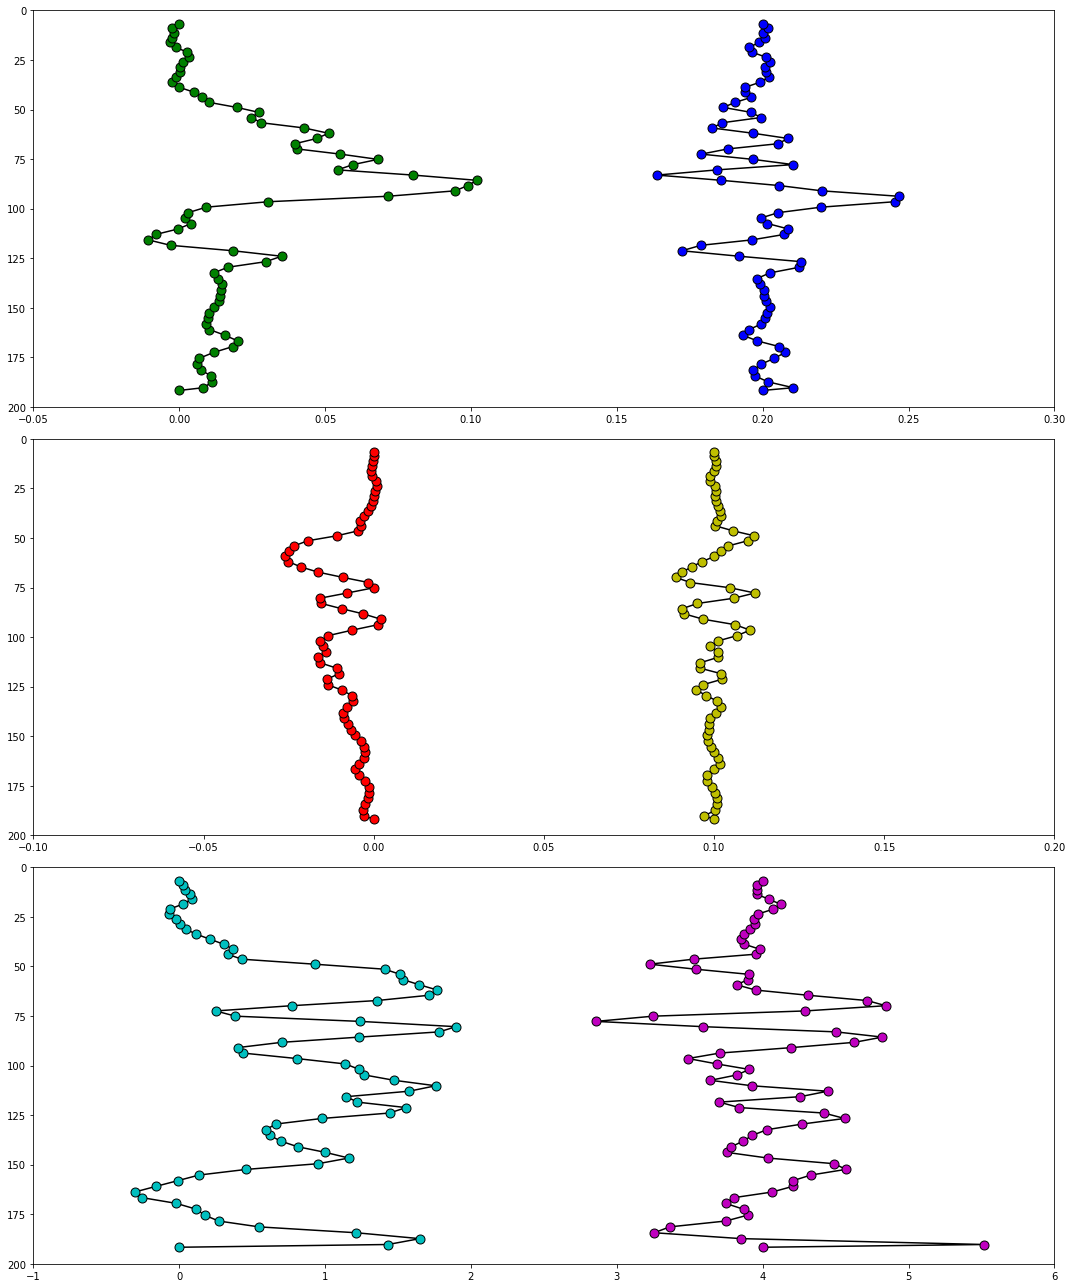

In [36]:
dydx1_t = dydx(ctd_t_filt, ctd_d)
dydx2_t = dydx(dydx1_t, ctd_d)
dydx1_s = dydx(ctd_s_filt, ctd_d)
dydx2_s = dydx(dydx1_s, ctd_d)
dydx1_o = dydx(ctd_o_filt, ctd_d)
dydx2_o = dydx(dydx1_o, ctd_d)

fig, axs = plt.subplots(3,1,figsize=(15,18), tight_layout=True)

axs[0].plot(                  dydx1_t, ctd_d, marker='o', markersize = 9., color='k', markerfacecolor='g')
axs[0].plot(dydx2_t*np.ones(70)*4+0.2, ctd_d, marker='o', markersize = 9., color='k', markerfacecolor='b')
axs[0].set(xlim = (-.05, .3), ylim = (200., 0.))

axs[1].plot(                  dydx1_s, ctd_d, marker='o', markersize = 9., color='k', markerfacecolor='r')
axs[1].plot(dydx2_s*np.ones(70)*4+0.1, ctd_d, marker='o', markersize = 9., color='k', markerfacecolor='y')
axs[1].set(xlim = (-.1, .2), ylim = (200., 0.))

axs[2].plot(                 dydx1_o, ctd_d, marker='o', markersize = 9., color='k', markerfacecolor='c')
axs[2].plot(dydx2_o*np.ones(70)*4+4., ctd_d, marker='o', markersize = 9., color='k', markerfacecolor='m')

axs[2].set(xlim = (-1, 6.), ylim = (200., 0.))


In [ ]:
sensor_d[-1]

## Profile as a class

The idea here is to create a Python class 'Profile' that can be used to organize many profiles.

In [ ]:
class Profile:
    """A water column profile"""
    
    def __init__(self, t0='2019-01-01T00:26:05', t1='2019-01-01T01:37:55', d0=191.268063, d1=6.618323, site='osb'):
        self.t0 = dt64(t0)
        self.t1 = dt64(t1)
        self.d0 = d0
        self.d1 = d1
        self.site = site

    def readout(self):
        print("Profile start", self.t0, 'duration', self.t1 - self.t0)

p = Profile()
p.readout()

## How many profiles ran in January 2019?

At nine per day and 31 days we should have 279 profiles. The Crawler finds only 278 so either the
algorithm is faulty or a profile was skipped. By looking at the depth chart we see it is the latter case. 

In [ ]:
# January 2019 has all but one profile correct (278 / 279 possible). 
#   Missing is the last profile of the month.
# For each given UTC day: Profiles 4 and 9 are pH profiles.
#   Could use time window criteria: Hour on [6, 10] and [19, 23].

fig, axs = plt.subplots(16, 1, figsize=(15,31), tight_layout=True)

for i in range(31):
    daystring = str(i+1) if i > 8 else '0' + str(i+1)
    time0, time1 = '2019-01-' + daystring + 'T00:00:00', '2019-01-' + daystring + 'T23:59:59'
    ds = ds_CTD.sel(time=slice(time0, time1))
    axs[i].plot(ds.time, ds.seawater_pressure, marker='.', markersize=1., color='k')
    axs[i].set(ylim = (200., 0.))

print('...January 2019 OSB depth profiles...')